## Imports and data

In [1]:
import pandas as pd
import numpy as np

# Sklearn imports
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Metrics
from sklearn.metrics import auc, roc_auc_score, roc_curve

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Save model
import pickle
import json

# I'd like to see all columns
pd.set_option('display.max_columns', None)
# And no warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Let's take a look on data we have
df_all = pd.read_csv('dataset.csv', sep=';')
df_all.head()

,uuid,default,account_amount_added_12_24m,account_days_in_dc_12_24m,account_days_in_rem_12_24m,account_days_in_term_12_24m,account_incoming_debt_vs_paid_0_24m,account_status,account_worst_status_0_3m,account_worst_status_12_24m,account_worst_status_3_6m,account_worst_status_6_12m,age,avg_payment_span_0_12m,avg_payment_span_0_3m,merchant_category,merchant_group,has_paid,max_paid_inv_0_12m,max_paid_inv_0_24m,name_in_email,num_active_div_by_paid_inv_0_12m,num_active_inv,num_arch_dc_0_12m,num_arch_dc_12_24m,num_arch_ok_0_12m,num_arch_ok_12_24m,num_arch_rem_0_12m,num_arch_written_off_0_12m,num_arch_written_off_12_24m,num_unpaid_bills,status_last_archived_0_24m,status_2nd_last_archived_0_24m,status_3rd_last_archived_0_24m,status_max_archived_0_6_months,status_max_archived_0_12_months,status_max_archived_0_24_months,recovery_debt,sum_capital_paid_account_0_12m,sum_capital_paid_account_12_24m,sum_paid_inv_0_12m,time_hours,worst_status_active_inv
0,63f69b2c-8b1c-4740-b78d-52ed9a4515ac,0.0,0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,1.0,NaN,20,12.692308,8.333333,Dietary supplements,Health & Beauty,True,31638.0,31638.0,no_match,0.153846,2,0,0,13,14,0,0.0,0.0,2,1,1,1,1,1,1,0,0,0,178839,9.653333,1.0
1,0e961183-8c15-4470-9a5e-07a1bd207661,0.0,0,0.0,0.0,0.0,NaN,1.0,1.0,1.0,1.0,1.0,50,25.833333,25.000000,Books & Magazines,Entertainment,True,13749.0,13749.0,F+L,0.000000,0,0,0,9,19,3,0.0,0.0,0,1,1,1,1,2,2,0,0,0,49014,13.181389,NaN
2,d8edaae6-4368-44e0-941e-8328f203e64e,0.0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,22,20.000000,18.000000,Diversified entertainment,Entertainment,True,29890.0,29890.0,L1+F,0.071429,1,0,0,11,0,3,0.0,0.0,1,1,1,1,1,2,2,0,0,0,124839,11.561944,1.0
3,0095dfb6-a886-4e2a-b056-15ef45fdb0ef,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36,4.687500,4.888889,Diversified entertainment,Entertainment,True,40040.0,40040.0,F1+L,0.031250,1,0,0,31,21,0,0.0,0.0,1,1,1,1,1,1,1,0,0,0,324676,15.751111,1.0
4,c8f8b835-5647-4506-bf15-49105d8af30b,0.0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,25,13.000000,13.000000,Electronic equipment & Related accessories,Electronics,True,7100.0,7100.0,F+L,0.000000,0,0,0,1,0,0,0.0,0.0,0,1,0,0,1,1,1,0,0,0,7100,12.698611,NaN


In [3]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99976 entries, 0 to 99975
Data columns (total 43 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   uuid                                 99976 non-null  object 
 1   default                              89976 non-null  float64
 2   account_amount_added_12_24m          99976 non-null  int64  
 3   account_days_in_dc_12_24m            88140 non-null  float64
 4   account_days_in_rem_12_24m           88140 non-null  float64
 5   account_days_in_term_12_24m          88140 non-null  float64
 6   account_incoming_debt_vs_paid_0_24m  40661 non-null  float64
 7   account_status                       45603 non-null  float64
 8   account_worst_status_0_3m            45603 non-null  float64
 9   account_worst_status_12_24m          33215 non-null  float64
 10  account_worst_status_3_6m            42274 non-null  float64
 11  account_worst_status_6_12m  

The data has a lot of missing values, additionally some variables can be highly correlated. Let's take a deeper look on missing data.

## 1. Data preprocessing

#### Missing values

In [4]:
# Let's take a look on these 3 columns account_days_in_dc_12_24m, account_days_in_rem_12_24m, account_days_in_term_12_24m
# If one is NA the others are also NA values. It is likely because they didn't add any money to the account. Let's check it
print(df_all[df_all['account_days_in_dc_12_24m'].isna() == True]['account_amount_added_12_24m'].value_counts())
df_all[df_all['account_days_in_dc_12_24m'].isna() == True]

0    11836
Name: account_amount_added_12_24m, dtype: int64


,uuid,default,account_amount_added_12_24m,account_days_in_dc_12_24m,account_days_in_rem_12_24m,account_days_in_term_12_24m,account_incoming_debt_vs_paid_0_24m,account_status,account_worst_status_0_3m,account_worst_status_12_24m,account_worst_status_3_6m,account_worst_status_6_12m,age,avg_payment_span_0_12m,avg_payment_span_0_3m,merchant_category,merchant_group,has_paid,max_paid_inv_0_12m,max_paid_inv_0_24m,name_in_email,num_active_div_by_paid_inv_0_12m,num_active_inv,num_arch_dc_0_12m,num_arch_dc_12_24m,num_arch_ok_0_12m,num_arch_ok_12_24m,num_arch_rem_0_12m,num_arch_written_off_0_12m,num_arch_written_off_12_24m,num_unpaid_bills,status_last_archived_0_24m,status_2nd_last_archived_0_24m,status_3rd_last_archived_0_24m,status_max_archived_0_6_months,status_max_archived_0_12_months,status_max_archived_0_24_months,recovery_debt,sum_capital_paid_account_0_12m,sum_capital_paid_account_12_24m,sum_paid_inv_0_12m,time_hours,worst_status_active_inv
3,0095dfb6-a886-4e2a-b056-15ef45fdb0ef,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36,4.687500,4.888889,Diversified entertainment,Entertainment,True,40040.0,40040.0,F1+L,0.031250,1,0,0,31,21,0,0.0,0.0,1,1,1,1,1,1,1,0,0,0,324676,15.751111,1.0
11,4f39ff19-6ee4-4944-b8f1-bd075392cbfc,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21,NaN,NaN,Diversified entertainment,Entertainment,False,0.0,0.0,F+L,NaN,0,0,0,0,0,0,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,11.948611,NaN
17,99f26027-f7c9-4ce8-8dcc-440c0ff17bd3,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29,27.500000,39.000000,Books & Magazines,Entertainment,True,6010.0,6010.0,F+L,0.000000,0,0,0,3,1,1,0.0,0.0,0,2,1,1,2,2,2,0,0,0,17670,19.686667,NaN
22,0714405e-0328-43f9-9be2-63df4c79b4c2,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23,77.500000,NaN,Youthful Shoes & Clothing,Clothing & Shoes,True,13658.0,13658.0,F1+L,0.333333,1,2,0,0,5,0,0.0,0.0,1,3,3,2,0,3,3,0,0,0,25417,22.710278,1.0
36,91ff473c-a0c1-4640-b591-0294745fb12c,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38,15.500000,NaN,Diversified entertainment,Entertainment,True,4480.0,4480.0,F+L,0.000000,0,0,0,2,0,0,0.0,0.0,0,1,1,2,0,1,2,0,0,0,6275,13.087778,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99921,c0b49f9b-ac39-455c-8fde-896092a6d731,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43,27.000000,48.000000,Diversified entertainment,Entertainment,True,3560.0,8621.0,L1+F,0.333333,1,0,0,2,0,1,0.0,0.0,1,2,1,1,2,2,2,0,0,0,9080,21.653889,1.0
99938,5656fb61-d573-4ed9-9600-beed8c27d08f,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45,13.500000,12.666667,Dietary supplements,Health & Beauty,True,27485.0,27485.0,F1+L,0.062500,1,0,0,14,7,0,0.0,0.0,1,1,1,1,1,1,1,0,0,0,105561,9.065278,1.0
99949,9e2acfd1-3e4b-4e33-995b-69c184c10871,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49,27.017857,26.666667,Diversified entertainment,Entertainment,True,7390.0,12990.0,no_match,0.031746,2,0,0,54,94,1,0.0,0.0,2,1,1,1,1,2,2,0,0,0,136892,12.618056,1.0
99950,0dd34e63-0a32-48f9-b83b-b5b2cd50370d,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38,5.000000,5.000000,Diversified entertainment,Entertainment,True,1190.0,1190.0,no_match,0.000000,0,0,0,1,0,0,0.0,0.0,0,1,0,0,1,1,1,0,0,0,1190,19.784722,NaN


In [5]:
# Additionally these clients have no account_incoming_debt_vs_paid_0_24m. Let's replace these values with "0"
columns = ['account_days_in_rem_12_24m', 'account_days_in_term_12_24m', 'account_incoming_debt_vs_paid_0_24m', 'account_days_in_dc_12_24m']
for i in columns:
    df_all.loc[df_all['account_days_in_dc_12_24m'].isna() == True, i] = 0
    
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99976 entries, 0 to 99975
Data columns (total 43 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   uuid                                 99976 non-null  object 
 1   default                              89976 non-null  float64
 2   account_amount_added_12_24m          99976 non-null  int64  
 3   account_days_in_dc_12_24m            99976 non-null  float64
 4   account_days_in_rem_12_24m           99976 non-null  float64
 5   account_days_in_term_12_24m          99976 non-null  float64
 6   account_incoming_debt_vs_paid_0_24m  52497 non-null  float64
 7   account_status                       45603 non-null  float64
 8   account_worst_status_0_3m            45603 non-null  float64
 9   account_worst_status_12_24m          33215 non-null  float64
 10  account_worst_status_3_6m            42274 non-null  float64
 11  account_worst_status_6_12m  

In [6]:
# Columns account_incoming_debt_vs_paid_0_24m and statuses. Let's assume that incoming debt vs paid in that case is 0.
# As for statuses we have categories 1,2,3,4 let's add category "unknown" and encode it as "0".
columns = ['account_incoming_debt_vs_paid_0_24m', 'account_status', 'account_worst_status_0_3m', 'account_worst_status_12_24m',
          'account_worst_status_3_6m', 'account_worst_status_6_12m']
df_all[columns] = df_all[columns].fillna(0)

In [7]:
# Columns avg payment spans. Here let's assume that missing values are averages according to each merchant group "Entertainmet", 
# "Heath & Beaty" etc.
groups = list(df_all['merchant_group'].unique())
averages_avg_payment_span_0_12m = {}
averages_avg_payment_span_0_3m = {}

for i in groups:
    mean_1 = df_all[df_all['merchant_group'] == i]['avg_payment_span_0_12m'].mean()
    mean_2 = df_all[df_all['merchant_group'] == i]['avg_payment_span_0_3m'].mean()
    averages_avg_payment_span_0_12m[i] = mean_1
    averages_avg_payment_span_0_3m[i] = mean_2    

In [8]:
for i in groups:
    df_all.loc[(df_all['merchant_group'] == i) & (df_all['avg_payment_span_0_12m'].isna() == True), 
               'avg_payment_span_0_12m'] = averages_avg_payment_span_0_12m[i]
    df_all.loc[(df_all['merchant_group'] == i) & (df_all['avg_payment_span_0_3m'].isna() == True), 
               'avg_payment_span_0_3m'] = averages_avg_payment_span_0_3m[i]

In [9]:
# Columns num_active_div_by_paid_inv_0_12m, num_arch_written_off and worst_status_active_inv
columns = ['num_active_div_by_paid_inv_0_12m', 'num_arch_written_off_0_12m', 'num_arch_written_off_12_24m', 'worst_status_active_inv']
for i in columns:
    print(df_all[i].value_counts())

0.000000    48706
1.000000     2425
0.500000     2273
0.333333     1918
0.250000     1683
            ...  
0.013793        1
0.107692        1
0.029703        1
0.255814        1
0.017094        1
Name: num_active_div_by_paid_inv_0_12m, Length: 861, dtype: int64
0.0    81888
1.0       10
Name: num_arch_written_off_0_12m, dtype: int64
0.0    81887
1.0        9
2.0        2
Name: num_arch_written_off_12_24m, dtype: int64
1.0    26922
2.0     3369
3.0      170
Name: worst_status_active_inv, dtype: int64


In [10]:
# Let's replace with 0 values. Again for statuus columns "0" means "unknown"
df_all[columns] = df_all[columns].fillna(0)
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99976 entries, 0 to 99975
Data columns (total 43 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   uuid                                 99976 non-null  object 
 1   default                              89976 non-null  float64
 2   account_amount_added_12_24m          99976 non-null  int64  
 3   account_days_in_dc_12_24m            99976 non-null  float64
 4   account_days_in_rem_12_24m           99976 non-null  float64
 5   account_days_in_term_12_24m          99976 non-null  float64
 6   account_incoming_debt_vs_paid_0_24m  99976 non-null  float64
 7   account_status                       99976 non-null  float64
 8   account_worst_status_0_3m            99976 non-null  float64
 9   account_worst_status_12_24m          99976 non-null  float64
 10  account_worst_status_3_6m            99976 non-null  float64
 11  account_worst_status_6_12m  

#### Encoding and data split

In [11]:
# Encode object columns (except user id)
ord_enc = OrdinalEncoder()
df_all[['merchant_category', 'merchant_group', 'name_in_email']] = ord_enc.fit_transform(df_all[['merchant_category', 'merchant_group', 'name_in_email']])

In [12]:
# Assign numeric value to variable 'has_paid'
label_encoder = LabelEncoder()
df_all['has_paid'] = label_encoder.fit_transform(df_all['has_paid'])

# Check with classes_
print(dict(enumerate(label_encoder.classes_)))

{0: False, 1: True}


In [13]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99976 entries, 0 to 99975
Data columns (total 43 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   uuid                                 99976 non-null  object 
 1   default                              89976 non-null  float64
 2   account_amount_added_12_24m          99976 non-null  int64  
 3   account_days_in_dc_12_24m            99976 non-null  float64
 4   account_days_in_rem_12_24m           99976 non-null  float64
 5   account_days_in_term_12_24m          99976 non-null  float64
 6   account_incoming_debt_vs_paid_0_24m  99976 non-null  float64
 7   account_status                       99976 non-null  float64
 8   account_worst_status_0_3m            99976 non-null  float64
 9   account_worst_status_12_24m          99976 non-null  float64
 10  account_worst_status_3_6m            99976 non-null  float64
 11  account_worst_status_6_12m  

In [14]:
# Split variables into 3 folders
target = ['default']
bin_cols = ['has_paid']
cat_cols = ['account_status', 'account_worst_status_0_3m', 'account_worst_status_12_24m', 'account_worst_status_3_6m', 
            'account_worst_status_6_12m', 'merchant_category', 'merchant_group', 'name_in_email', 'status_last_archived_0_24m',
            'status_2nd_last_archived_0_24m', 'status_3rd_last_archived_0_24m', 'status_max_archived_0_6_months',
            'status_max_archived_0_12_months', 'status_max_archived_0_24_months', 'worst_status_active_inv']
num_cols = list(df_all.drop(bin_cols + cat_cols + target + ['uuid'], axis=1).columns)

In [15]:
# Split data where we have the value of default and don't
df = df_all[df_all['default'].isna() == False]
df_to_predict = df_all[df_all['default'].isna() == True]

## 2. EDA

In [16]:
# Create function for numerical features analysis

def print_numerical(data, item_name, n_bins=100):
    
    '''This function creates 2 figures with box and distribution plots to analyze numeric variables'''
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 10))
        
    # boxplot    
    data.boxplot(column=item_name, ax=axes[0])
    axes[0].set_title(item_name, fontsize=22)
    
    # distplot
    sns.distplot(data[item_name], bins=n_bins, kde=False, ax=axes[1], vertical=True)
    axes[1].set_title(item_name, fontsize=22)
    plt.xticks(rotation=45)
        
#     # descriptive statistics
#     print(pd.DataFrame(data[item_name].describe()).T, "\n")

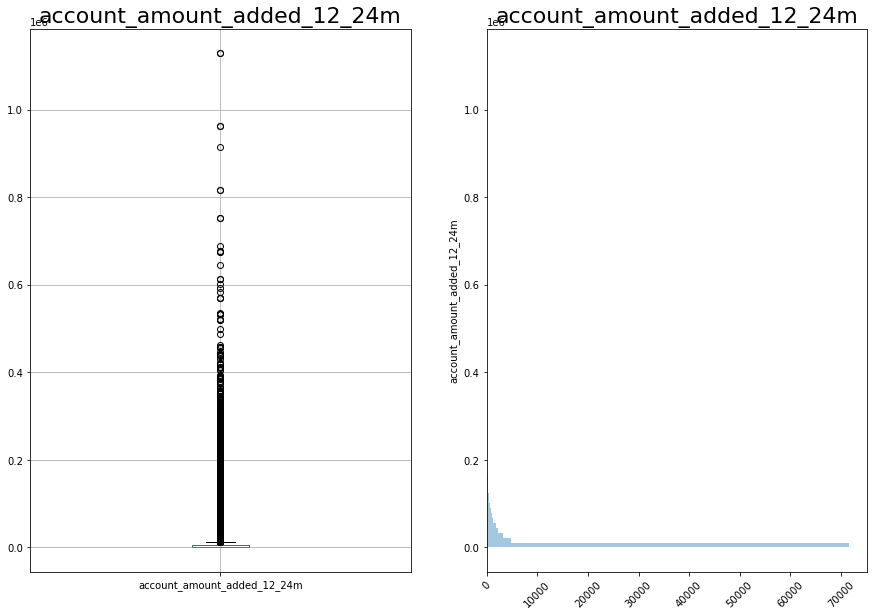

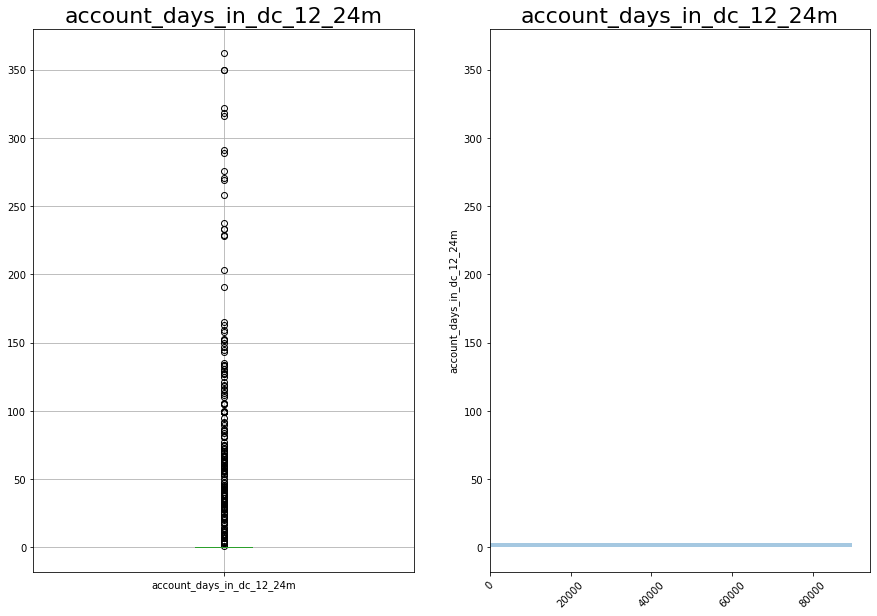

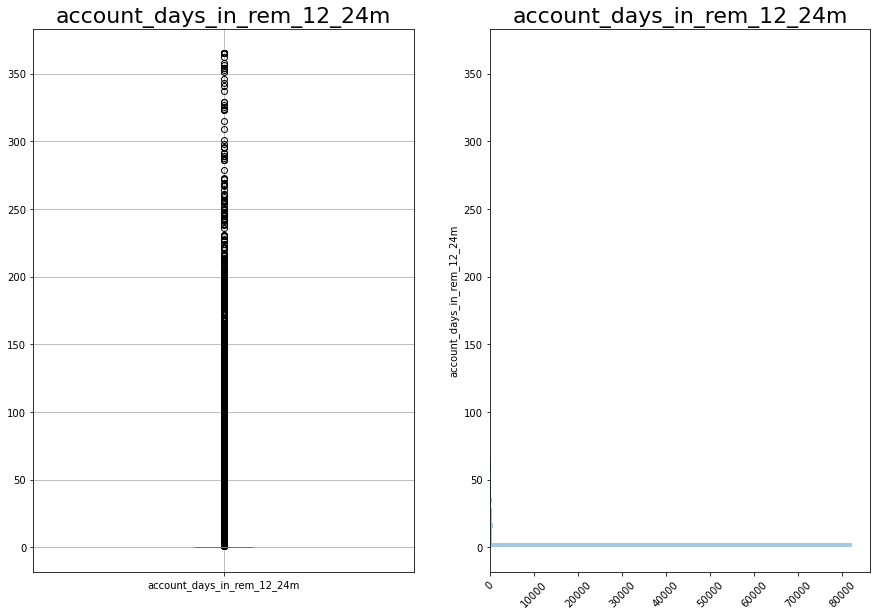

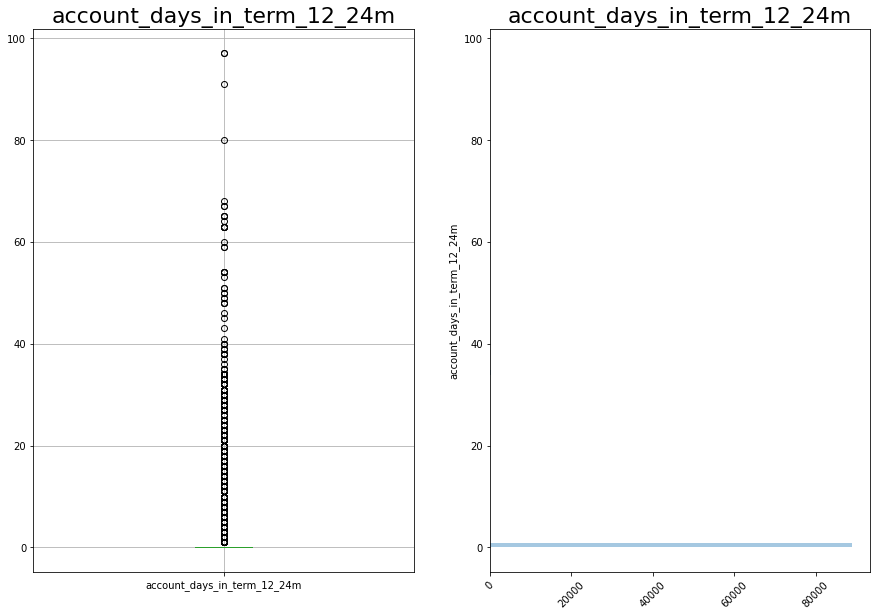

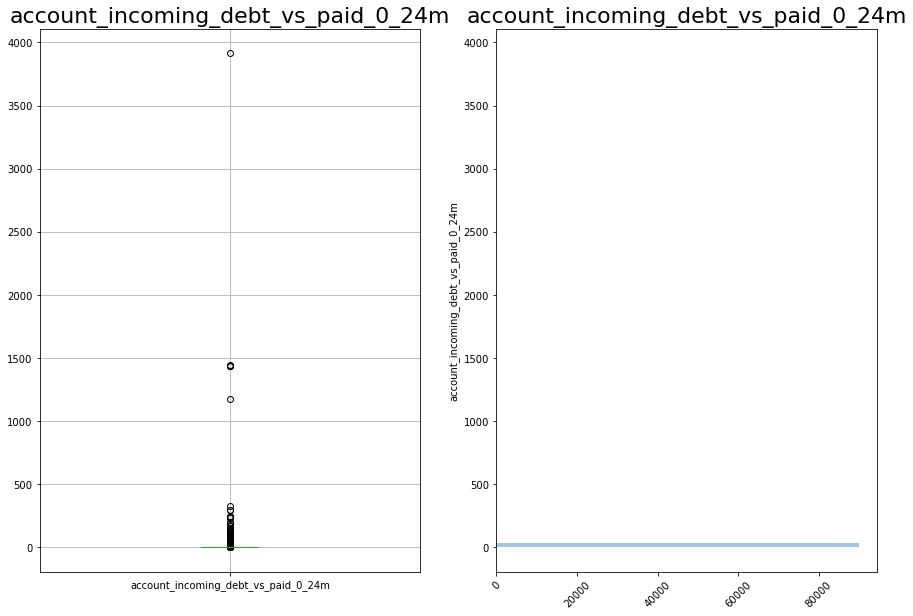

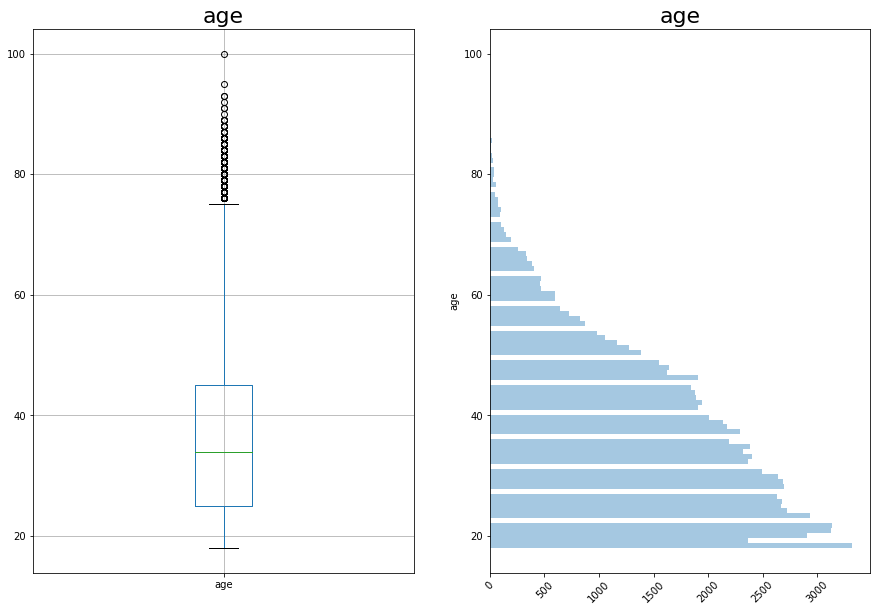

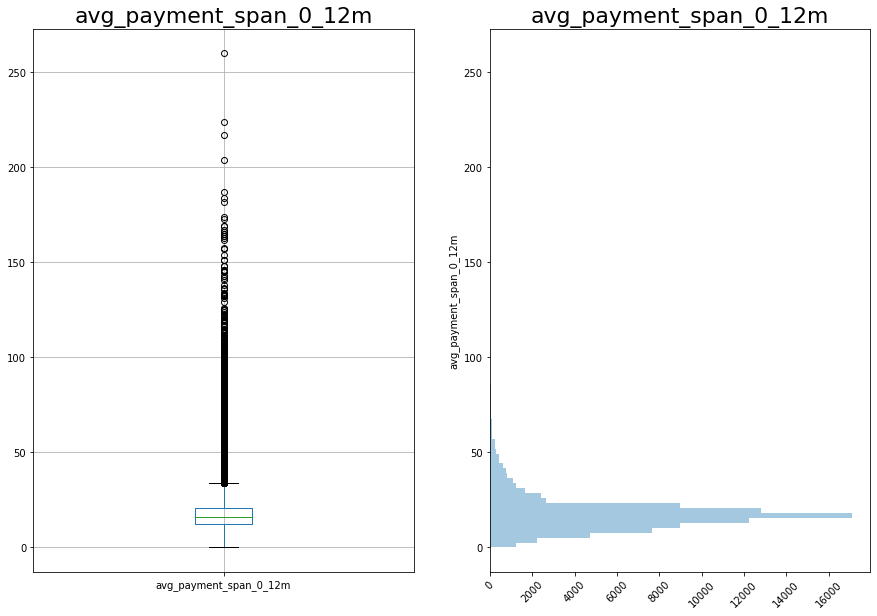

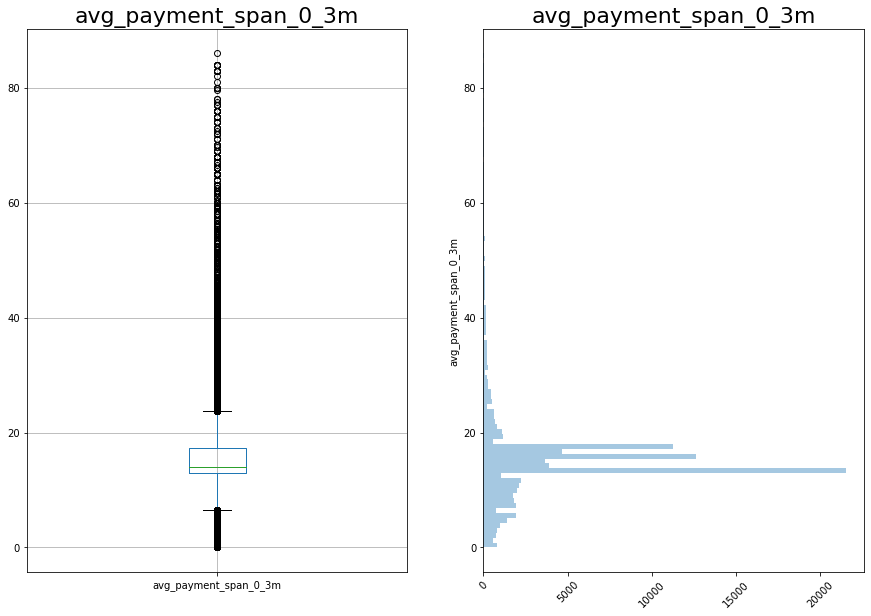

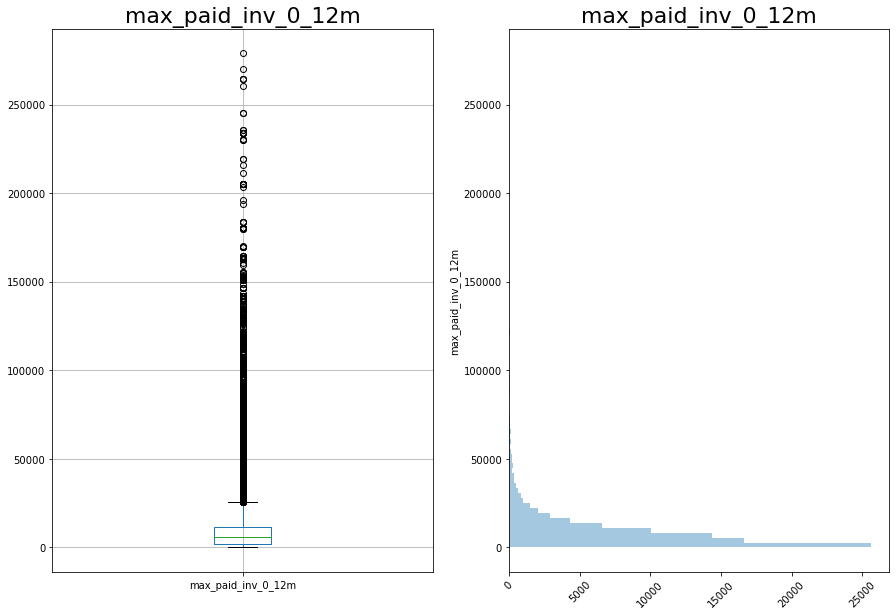

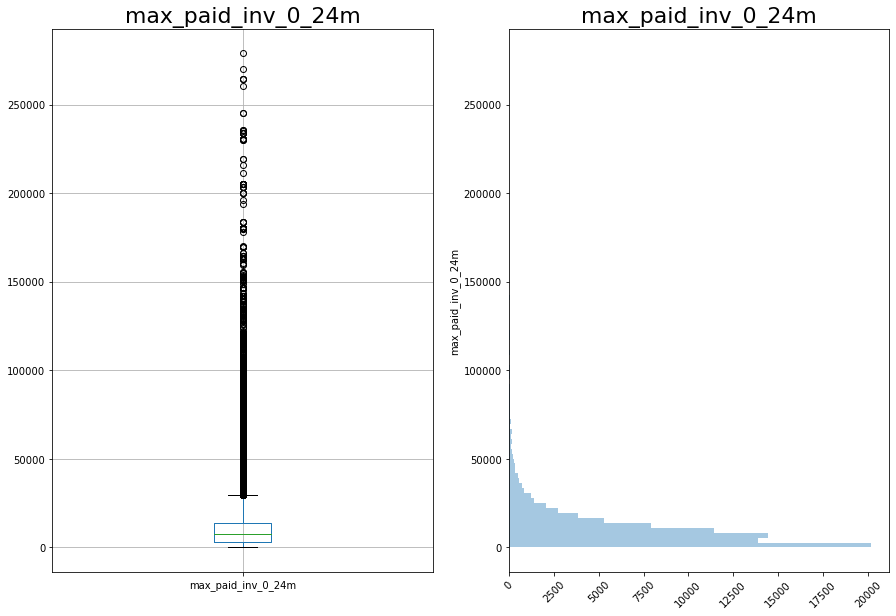

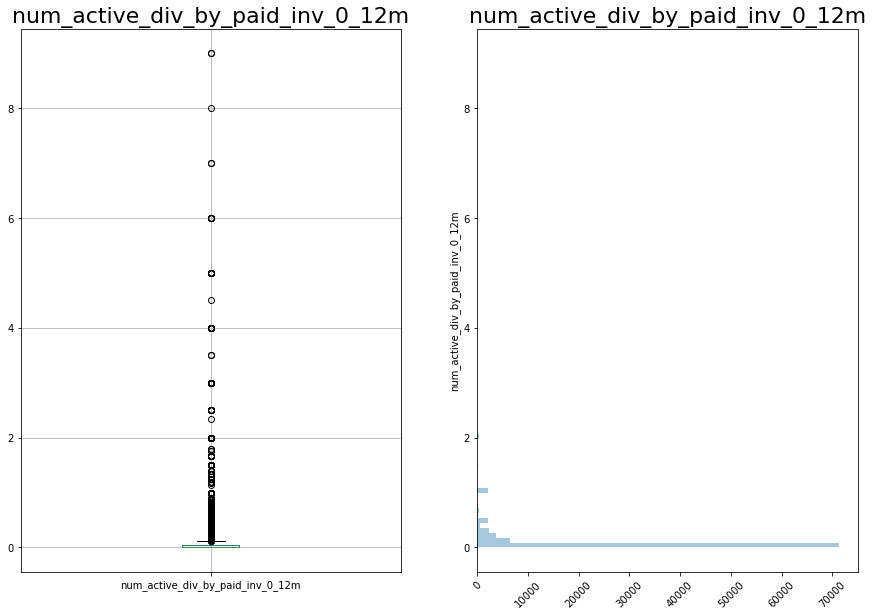

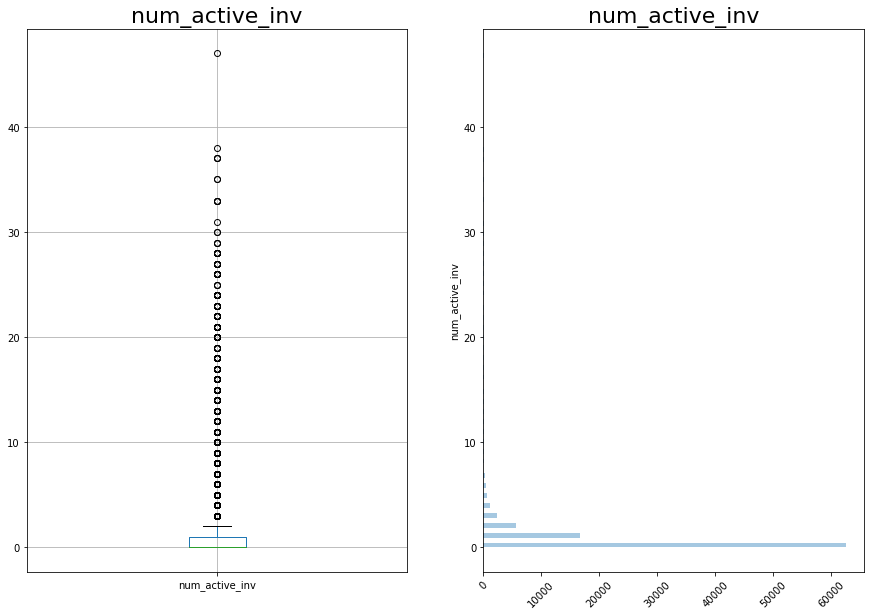

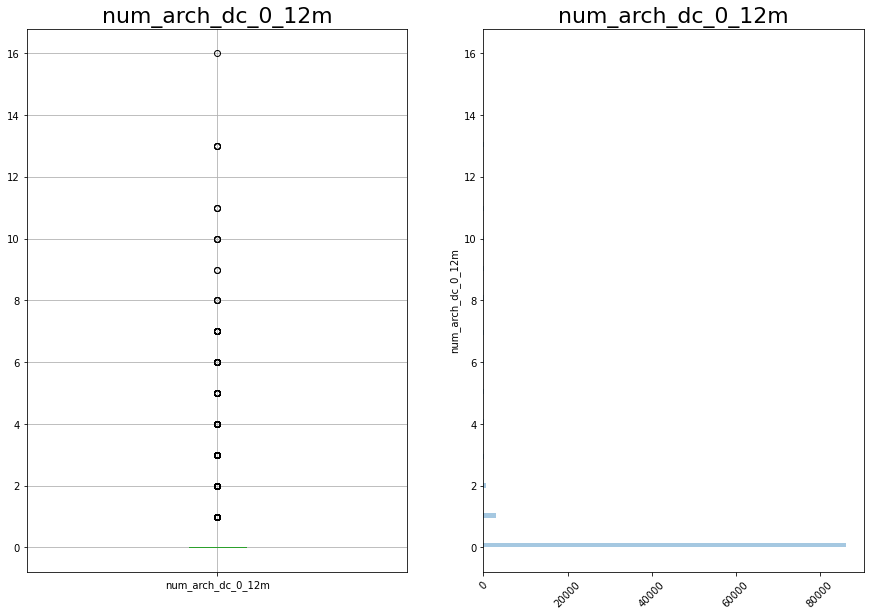

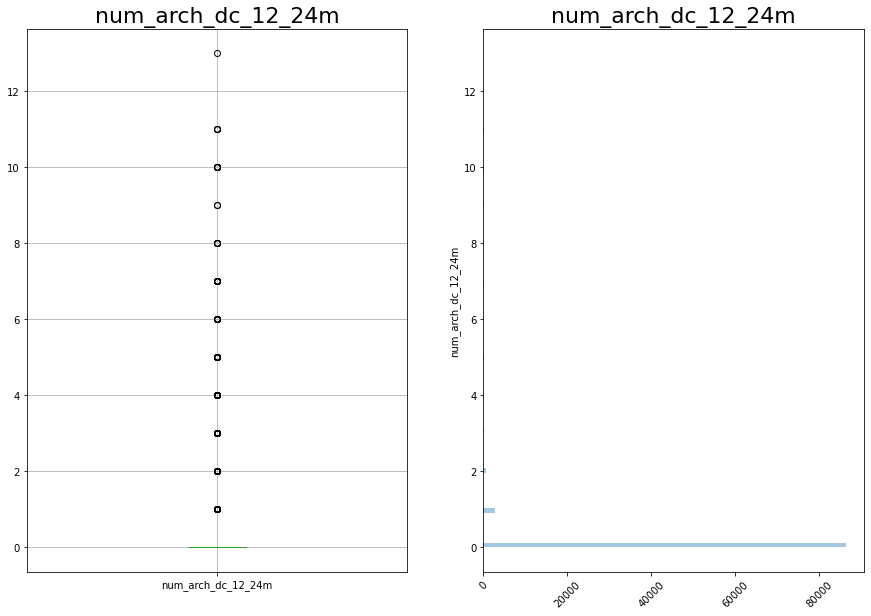

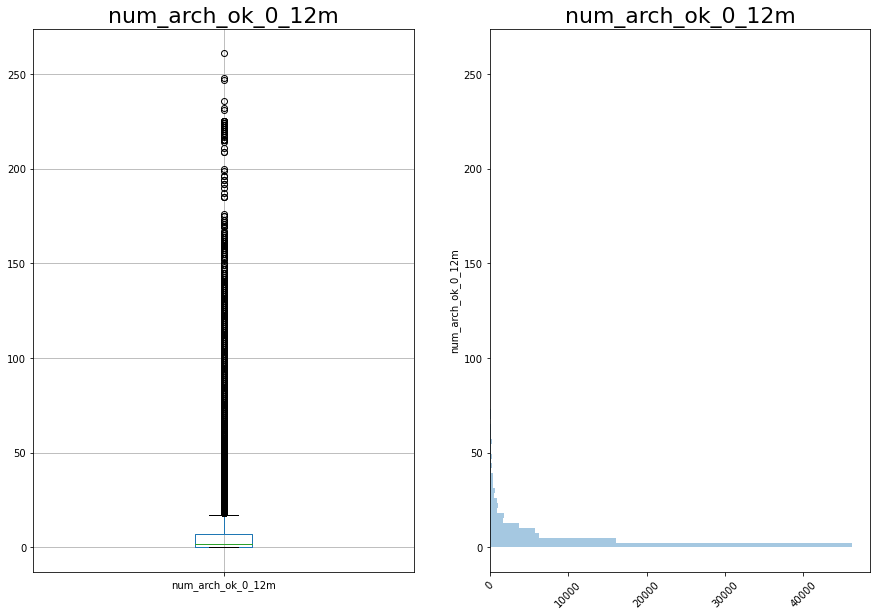

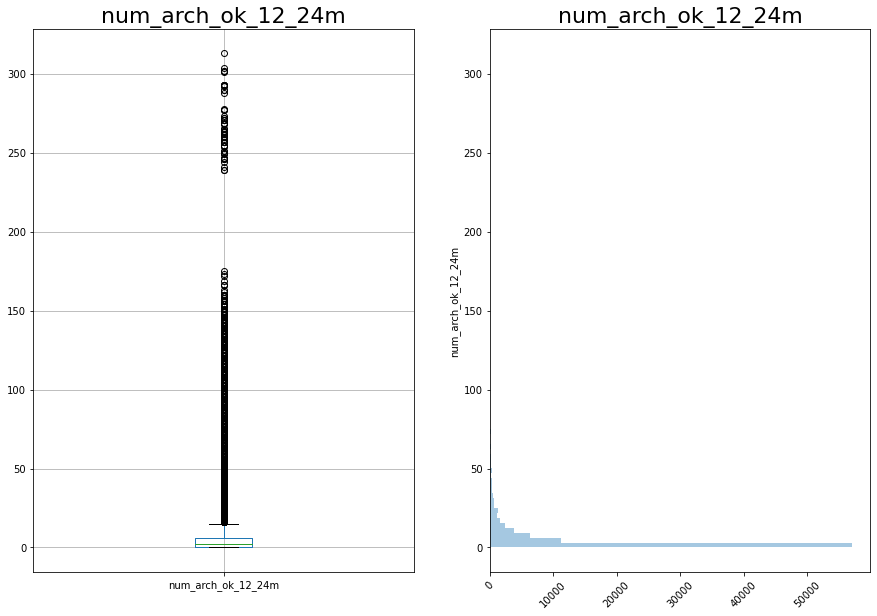

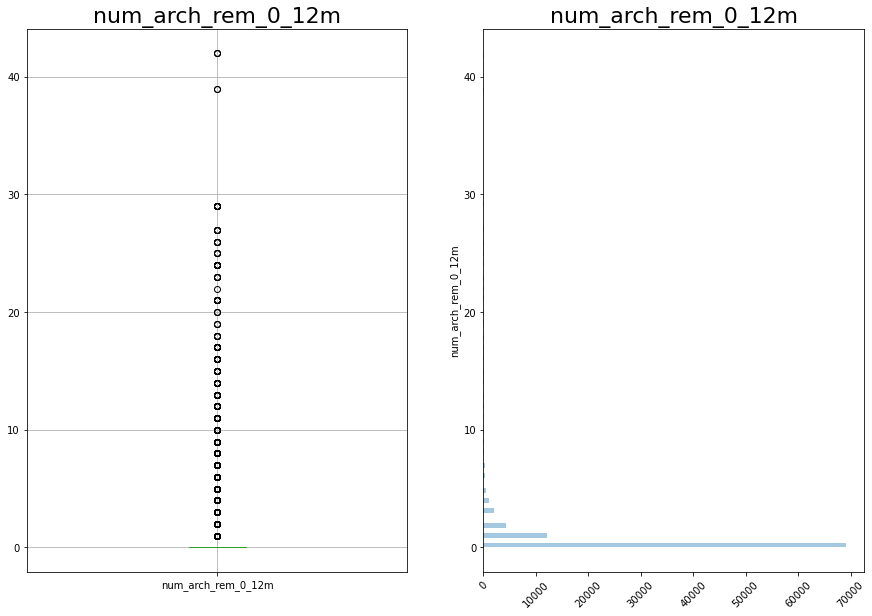

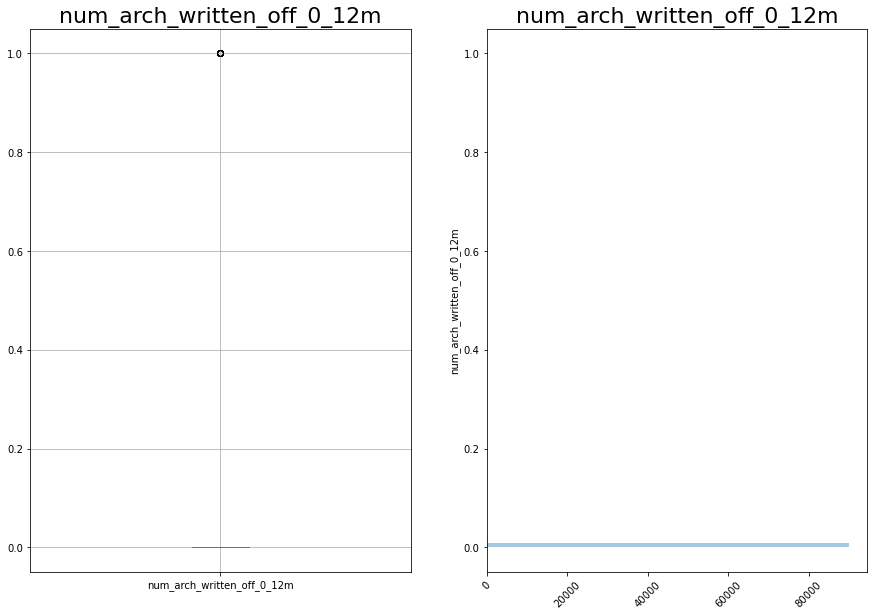

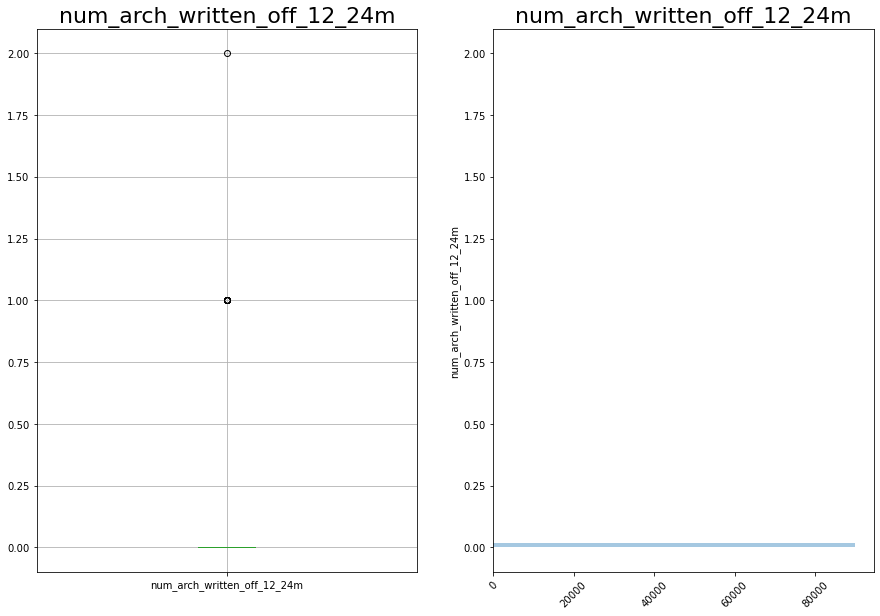

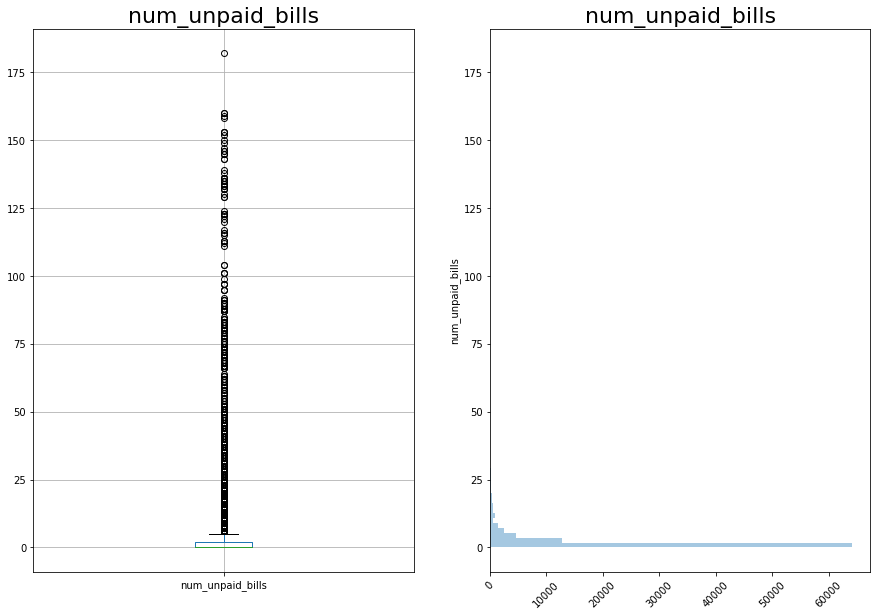

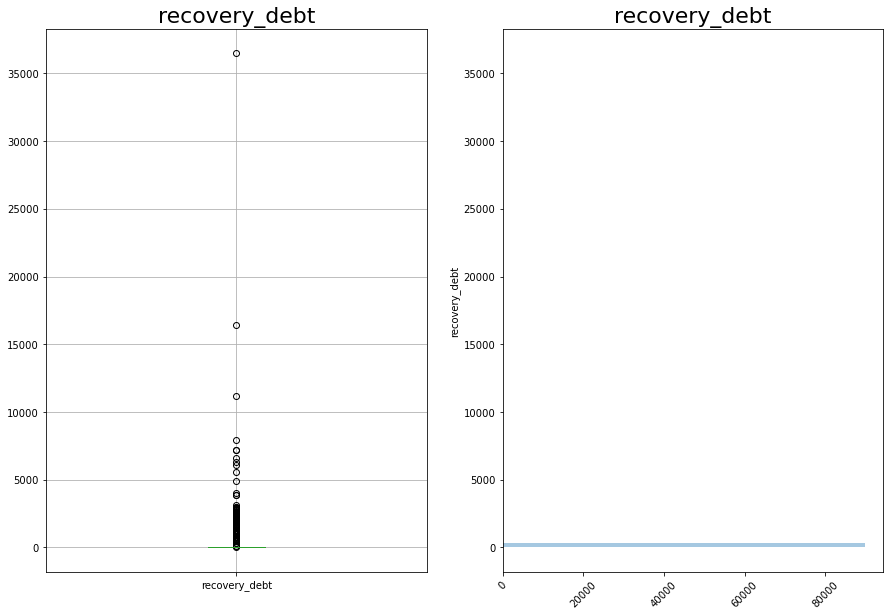

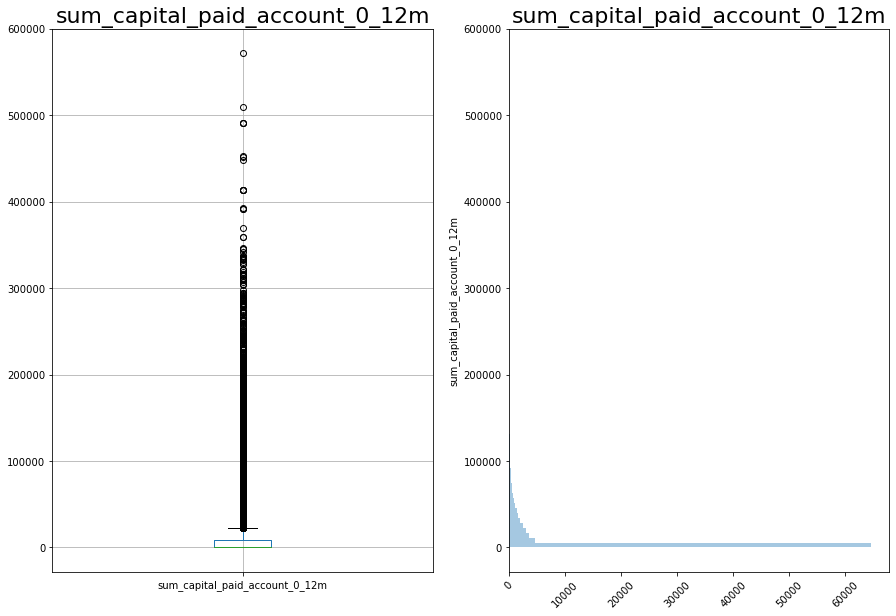

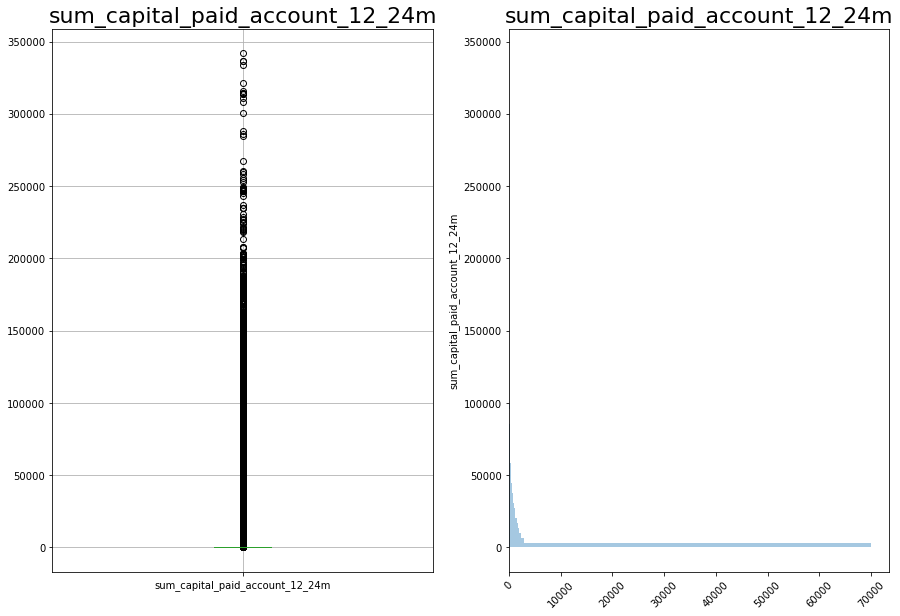

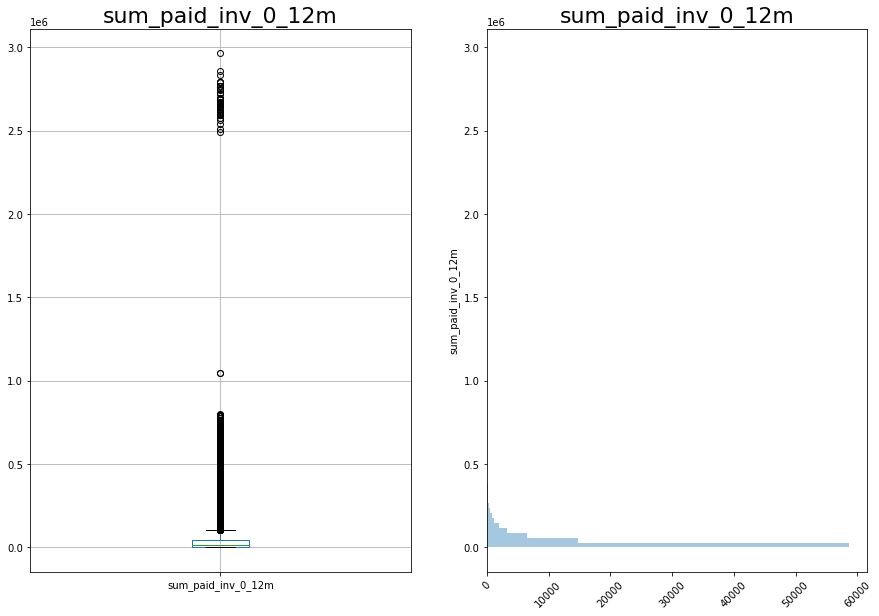

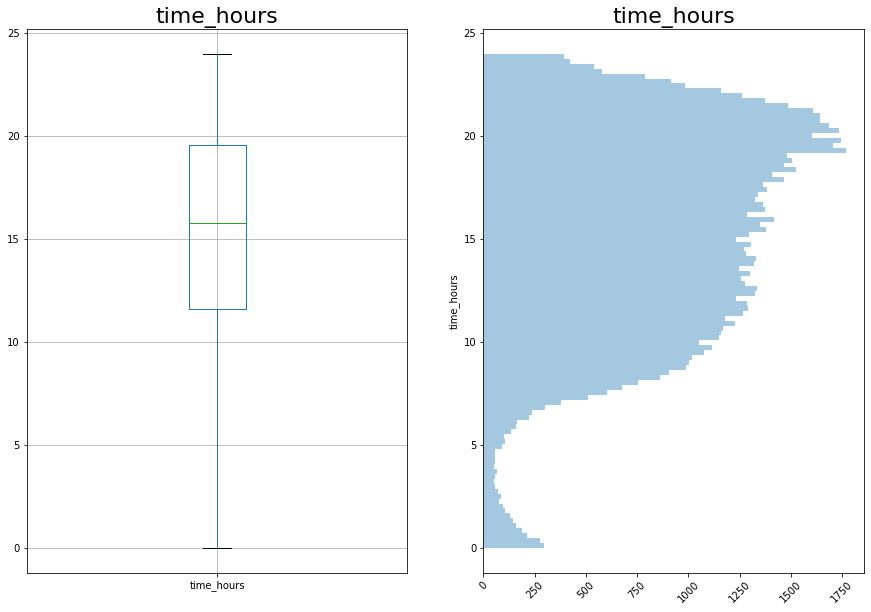

In [17]:
# Let's take a look on numeric columns
for i in num_cols:
    print_numerical(df, i)

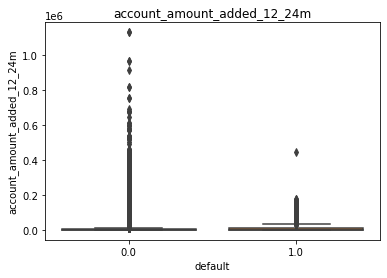

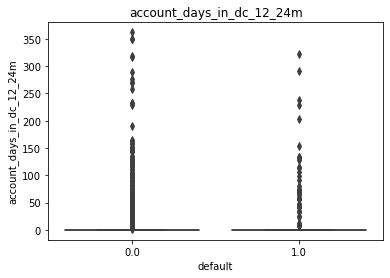

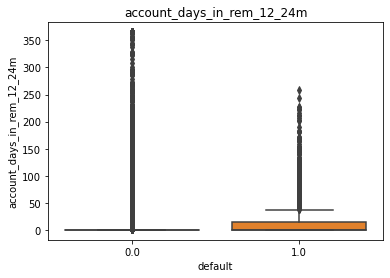

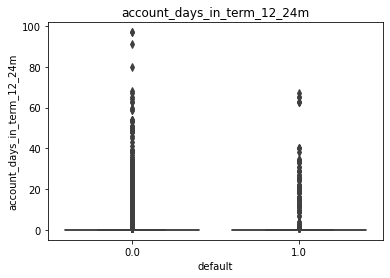

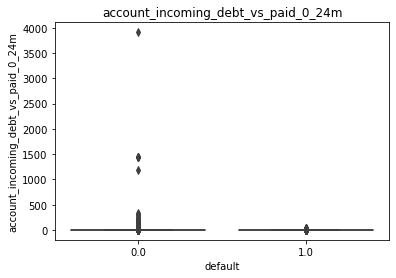

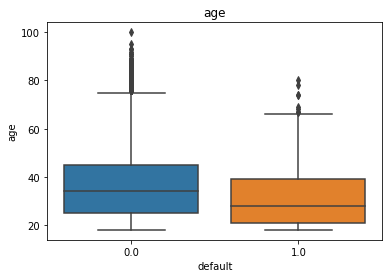

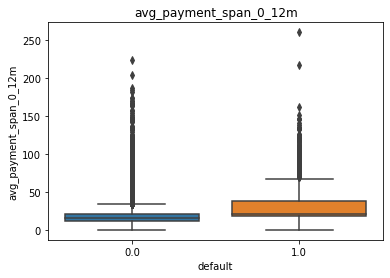

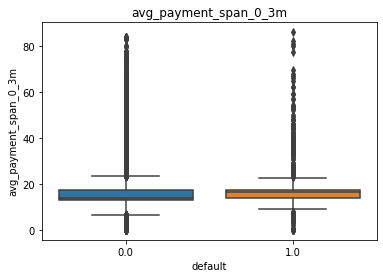

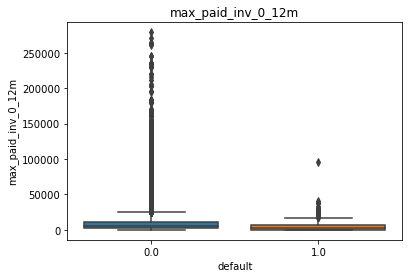

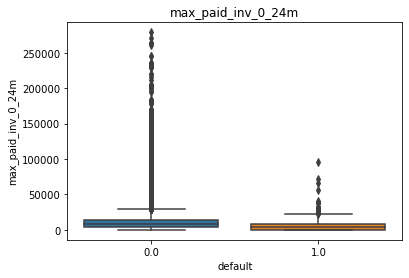

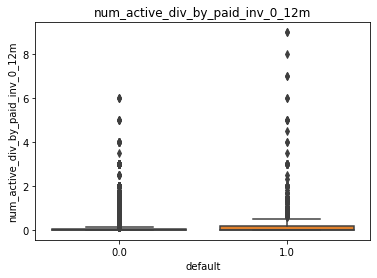

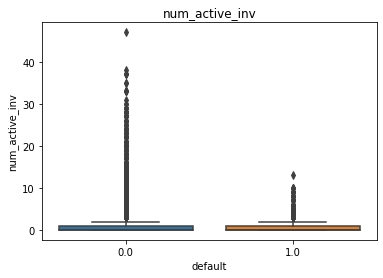

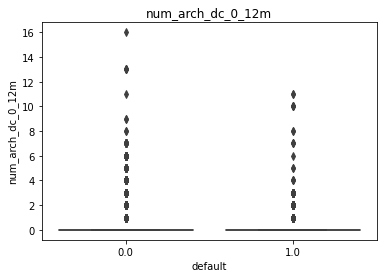

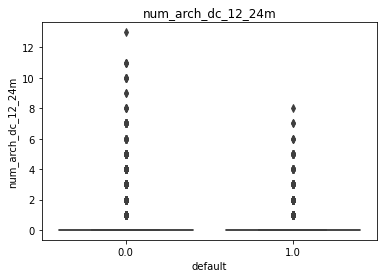

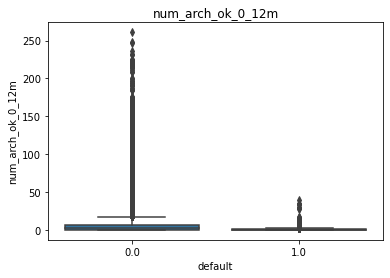

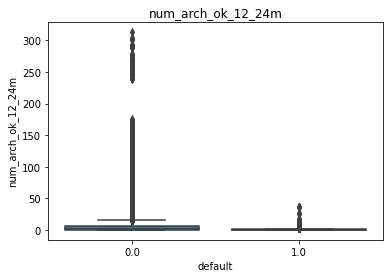

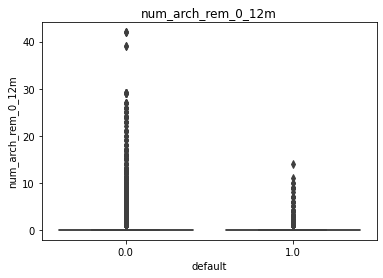

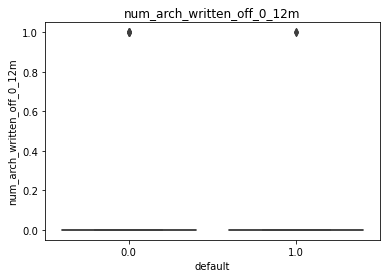

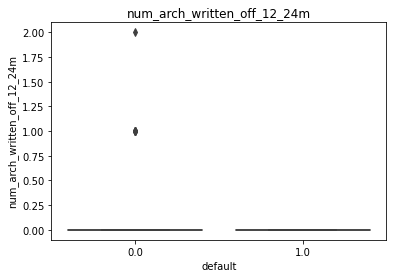

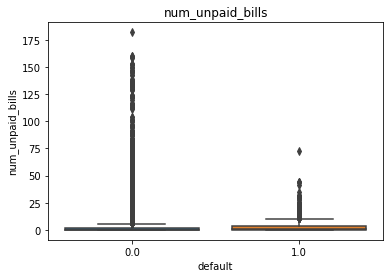

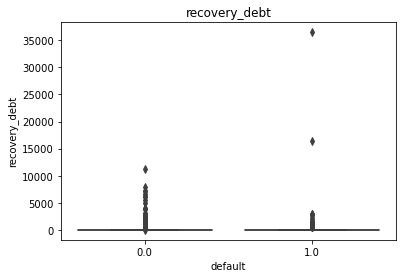

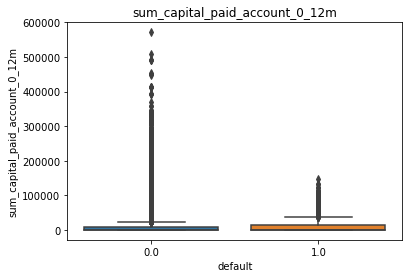

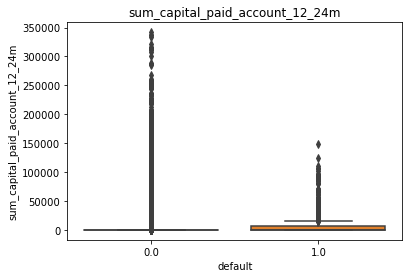

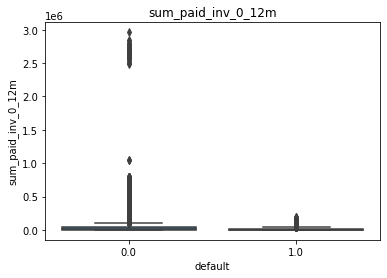

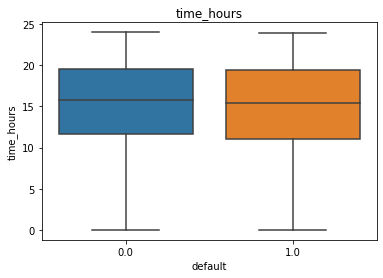

In [18]:
# Variables have a lot of 0 values and outliers, some of them might make no sense for us and will be removed.
# Let's fix target variable (default) on X axis and take a closer look on numeric boxplots
for i in num_cols:
    plt.figure()
    sns.boxplot(x = 'default', y = i, data=df)
    plt.title(i)
    plt.show()

In [19]:
# Let's remove following columns as they have almost all values as 0 and won't affect results. Time hours also make no sense
# based on boxplot it has same average and distribution for defaul and non default clients.
list_columns = ['num_arch_written_off_0_12m', 'num_arch_written_off_12_24m', 'time_hours']
num_cols = [elem for elem in num_cols if elem not in list_columns]

<AxesSubplot:>

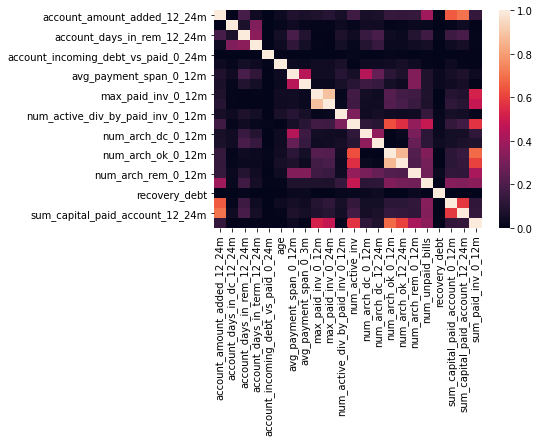

In [20]:
# Create correlation heatmap
sns.heatmap(df[num_cols].corr().abs(), vmin=0, vmax=1)

<AxesSubplot:>

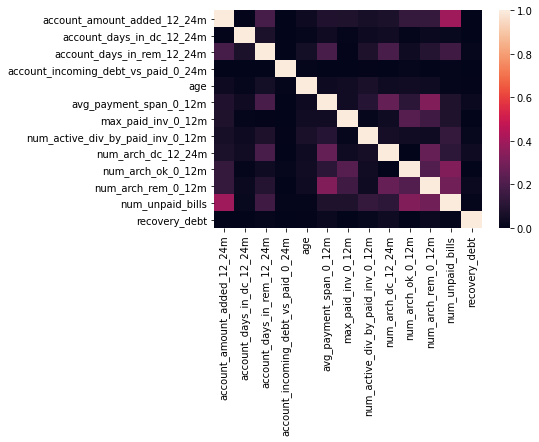

In [21]:
# Remove some high correlated columns (for example, max_paid_inv_0_12m and max_paid_inv_0_24m keep only one)
list_columns = ['max_paid_inv_0_24m', 'num_arch_dc_0_12m', 'num_arch_ok_12_24m', 'sum_capital_paid_account_0_12m',
               'sum_paid_inv_0_12m', 'sum_capital_paid_account_12_24m', 'num_active_inv', 'account_days_in_term_12_24m',
               'avg_payment_span_0_3m']
num_cols = [elem for elem in num_cols if elem not in list_columns]
sns.heatmap(df[num_cols].corr().abs(), vmin=0, vmax=1)

Now all variables are not highly correlated which allows to avoid multicollinearity in future model. What about outliers? Let's keep them for now as they are, because our data is very unbalanced and some statistically detected "outliers" might not be actual ones and can be considered as a "flag" of potential default cases.

#### General significancy of variables

<AxesSubplot:>

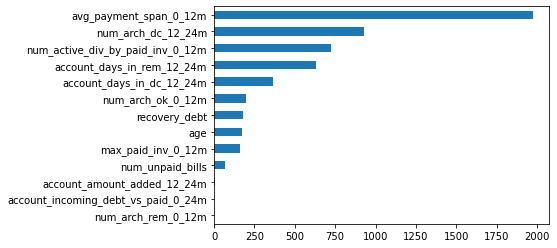

In [22]:
# General significancy of the rest of numeric variables (using F-score)
imp_num = pd.Series(f_classif(df[num_cols], df['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [23]:
# Remove 3 columns with 0 significancy
list_columns = ['account_amount_added_12_24m', 'account_incoming_debt_vs_paid_0_24m', 'num_arch_rem_0_12m']
num_cols = [elem for elem in num_cols if elem not in list_columns]

<AxesSubplot:>

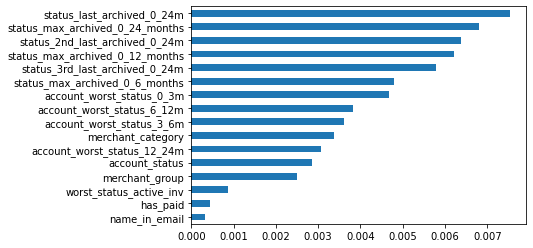

In [24]:
# Significancy of categorical and boolean columns
imp_cat = pd.Series(mutual_info_classif(df[bin_cols + cat_cols], df['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [25]:
# Update initial dataframe (keep columns we need only)
df_all = df_all[['uuid'] + target + num_cols + cat_cols + bin_cols]

In [26]:
# Split data again for train and test
df = df_all[df_all['default'].isna() == False]
df_to_predict = df_all[df_all['default'].isna() == True]

In [27]:
# Create X, Y
X = df[num_cols + cat_cols +  bin_cols].values
y = df[target].values

## 3. Models

#### Logistic Regression

In [28]:
# Create functions for working with models

# Train/test splitting
def splitting(X, Y):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    return X_train, X_test, y_train, y_test

# Roc AUC curve will be used as a metric to estimate the quality
def print_roc_curve(model):
    
    probs = model.predict_proba(X_test)
    probs = probs[:,1]
    
    fpr, tpr, threshold = roc_curve(y_test, probs)
    roc_auc = roc_auc_score(y_test, probs)
    
    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label = 'Regression')
    plt.title(f'ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()

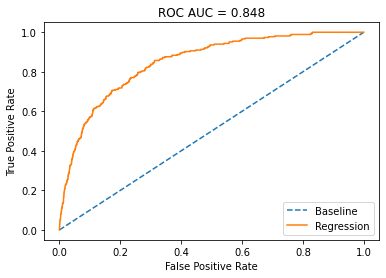

In [29]:
# Create model and plot roc_curve
X_train, X_test, y_train, y_test = splitting(X, y)

# Here we fit the model with 'balanced' class weights because WE HAVE UNBALANCED DATASET
lr = LogisticRegression(max_iter=300, class_weight='balanced')
lr.fit(X_train, y_train)

print_roc_curve(lr)

In [30]:
# Logistics regression shows good results with 0.87 score, let's try to improve just a bit :) with regularization
model = LogisticRegression(random_state=42)
iter_max = 300
param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_max]},
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_max]},
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_max]},
]

gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1)
gridsearch.fit(X_train, y_train)
best_model = gridsearch.best_estimator_
print(best_model)

LogisticRegression(class_weight='balanced', max_iter=300, penalty='none',
                   random_state=42, solver='newton-cg')


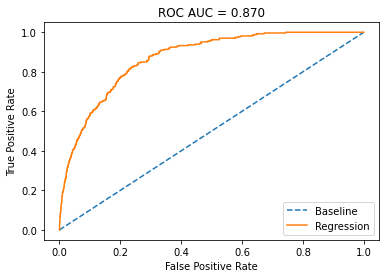

In [31]:
print_roc_curve(best_model) # Gives a bit better

We already reached out the best LogisticRegression model, let's keep it here and try another one to compare

#### XGBClassifier

In [32]:
# !pip install xgboost

In [33]:
# XG with random params
xg_class = xgb.XGBClassifier(colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 3000)
xg_class.fit(X_train,y_train)

[18:17:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=3000, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=10, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

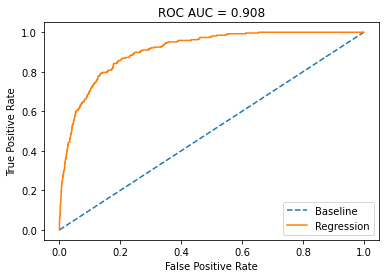

In [34]:
print_roc_curve(xg_class)

Got better results without any sort of fine-tunning. Let's try one more - RandomForest

#### Random Forest

In [35]:
#  Again use model with random parameters without tunning
rf = RandomForestClassifier(
 n_estimators=300, 
 min_samples_split=2,
 min_samples_leaf=1,
 max_features=10,
 max_depth=90,
 bootstrap=True, 
 random_state=42)

rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=90, max_features=10, n_estimators=300,
                       random_state=42)

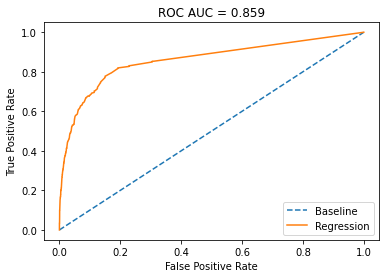

In [36]:
print_roc_curve(rf)

#### 3 Different models were used without significant fine-tunning (as said in task description). The best one is XGboost based on ROC AUC score. Let's keep this model, make predictions and save it for future production.

## 4. Predictions and saving the model

In [37]:
model = xg_class

In [38]:
X_pred = df_to_predict[num_cols + cat_cols +  bin_cols].values
y_pred = xg_class.predict_proba(X_pred)[:,1]

In [39]:
df_predicted = pd.DataFrame(df_to_predict.uuid).reset_index()
df_predicted = df_predicted.drop('index', axis=1)
df_predicted['pd'] = y_pred
df_predicted

,uuid,pd
0,6f6e6c6a-2081-4e6b-8eb3-4fd89b54b2d7,0.003186
1,f6f6d9f3-ef2b-4329-a388-c6a687f27e70,0.005533
2,e9c39869-1bc5-4375-b627-a2df70b445ea,0.010000
3,6beb88a3-9641-4381-beb6-c9a208664dd0,0.009745
4,bb89b735-72fe-42a4-ba06-d63be0f4ca36,0.061852
...,...,...
9995,5c03bc63-ea65-4ffd-aa7b-95ea9a46db34,0.000554
9996,f8db22f4-9819-420c-abbc-9ddf1843176e,0.003646
9997,b22e21ea-b1b2-4df3-b236-0ff6d5fdc0d8,0.192426
9998,bafcab15-9898-479c-b729-c9dda7edb78f,0.003779


In [41]:
# Save to csv
df_predicted.to_csv('submission.csv', index=False)

In [42]:
# Save model to pkl
filename = 'xgb_model.pkl'
pickle.dump(model, open(filename, 'wb'))

In [43]:
# Check it back
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.predict_proba(X_pred)[:,1]
print(result)

[0.00318627 0.00553282 0.00999973 ... 0.19242553 0.00377891 0.00415312]


In [44]:
# Save encoder for future usage
filename = 'encoder.pkl'
pickle.dump(ord_enc, open(filename, 'wb'))

In [45]:
# Random customer data as json
print(f'User id: {df_all["uuid"][90000]}')
json_obj = json.dumps(df_to_predict[num_cols + cat_cols +  bin_cols].loc[90000].to_dict())
print(json_obj)

User id: 4f1b8a2c-d178-4607-92ac-13457059047d
{"account_days_in_dc_12_24m": 0.0, "account_days_in_rem_12_24m": 0.0, "age": 61.0, "avg_payment_span_0_12m": 43.0, "max_paid_inv_0_12m": 5583.0, "num_active_div_by_paid_inv_0_12m": 1.0, "num_arch_dc_12_24m": 0.0, "num_arch_ok_0_12m": 1.0, "num_unpaid_bills": 2.0, "recovery_debt": 0.0, "account_status": 0.0, "account_worst_status_0_3m": 0.0, "account_worst_status_12_24m": 0.0, "account_worst_status_3_6m": 0.0, "account_worst_status_6_12m": 0.0, "merchant_category": 56.0, "merchant_group": 2.0, "name_in_email": 7.0, "status_last_archived_0_24m": 2.0, "status_2nd_last_archived_0_24m": 1.0, "status_3rd_last_archived_0_24m": 1.0, "status_max_archived_0_6_months": 2.0, "status_max_archived_0_12_months": 2.0, "status_max_archived_0_24_months": 2.0, "worst_status_active_inv": 2.0, "has_paid": 1.0}


#### All done! Please see 1-pager for summary and how to query the endpoint.